<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/numerical_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning for Art Market Valuation**

**This script provides the code for the numerical-only neural network model**

In [ ]:
import os
import shutil
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from scipy.stats import linregress

from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torchvision import datasets, transforms
from sklearn.model_selection import GridSearchCV
import random


drive.mount('/content/drive')
source_path = "/content/drive/My Drive/Colab Notebooks/numerical_model.ipynb"
destination_path = "/content/drive/My Drive/numerical_model.ipynb"

# Check if the source file exists before moving
if os.path.exists(source_path):
  # Move the file
  shutil.move(source_path, destination_path)
  print(f"Notebook moved to: {destination_path}")

!cp /content/drive/My\ Drive/data_preprocess.py /content/

from data_preprocess import (
    data_split as data_split,
    fit_visualization as fit_visualization,
    repeated_to_single_transactions as repeated_to_single_transactions,
    one_hot as one_hot,    data_filter as data_filter,
    get_location_dict as get_location_dict,
    add_location_column as add_location_column,
    load_image_data as load_image_data,
    check_image_existence as check_image_existence,
    filter_data_for_missing_images as filter_data_for_missing_images,

)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


class TransactionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.reset_index(drop=True).values.astype('float32')
        self.y = y.reset_index(drop=True).values.astype('float32')
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        x_sample = self.X[idx]
        y_sample = self.y[idx]
        return torch.tensor(x_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32)

def create_dataloaders(X_train, X_test, y_train, y_test,   batch_size=32):
    # Create the training dataset and dataloader
    train_dataset = TransactionDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True)
    # Create the testing dataset and dataloader
    test_dataset = TransactionDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=True)
    return train_loader, test_loader



class FeatureProjection(nn.Module):
    def __init__(self, in_features, output_dim=100):
        super(FeatureProjection, self).__init__()
        self.fc = nn.Linear(in_features, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.fc(x))

class Numerical_Model(nn.Module):
    def __init__(self, in_features, projection_output_dim=100):
        super(Numerical_Model, self).__init__()
        self.feature_projection = FeatureProjection(in_features, projection_output_dim)
        self.fc1 = nn.Linear(projection_output_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.feature_projection(x)
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x


def train(network, trainloader, testloader, epochs=30, eta=0.0001):
    optimizer = torch.optim.Adam(model.parameters(), lr=eta, weight_decay=1e-4)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = network.to(device)
    loss = torch.nn.MSELoss()
    val_loss = []

    for epoch in range(epochs):
        J_train = 0
        total_train_samples = 0  # Counter for number of train samples
        for x, t in trainloader:
            network.train()
            optimizer.zero_grad()
            x, t = x.to(device), t.to(device)
            z = network(x)
            t = t.view(-1, 1)
            J = loss(z, t)
            J_train += J.item() * x.size(0)
            total_train_samples += x.size(0)
            J.backward()
            optimizer.step()

        # Compute the average train loss
        avg_train_loss = J_train / total_train_samples

        # Test on validation data
        J_test = 0
        total_test_samples = 0  # Counter for number of test samples
        with torch.no_grad():
            network.eval()
            for x, t in testloader:
                x, t = x.to(device), t.to(device)
                z = network(x)
                t = t.view(-1, 1)
                J_test += loss(z, t).item() * t.size(0)
                total_test_samples += t.size(0)

        # Compute the average test loss
        avg_test_loss = J_test / total_test_samples


        # Print train and test loss for each epoch
        print(f'Epoch [{epoch + 1}/{epochs}]',
              f'Train loss: {avg_train_loss:.6f}',
              f'Test loss: {avg_test_loss:.6f}')

    # save predictions and targets after last epoch
    pred, target = [],[]
    with torch.no_grad():
      network.eval()
      for x, t in testloader:
        prediction = network(x.to(device))
        pred.extend(prediction.view(-1).detach().cpu().numpy())
        target.extend(t.view(-1).detach().cpu().numpy())

    return network, pred, target



Dateien entpackt in: /content/data
number of nans: 1201
missing images: 86
Total test samples: 5825
Test data shape : (5825, 766)
Train data shape : (57210, 766)
Std of y_test: 1.6869395890201688
Epoch [1/30] Train loss: 95.482271 Test loss: 55.596777
Epoch [2/30] Train loss: 27.256865 Test loss: 6.326400
Epoch [3/30] Train loss: 2.659321 Test loss: 0.900950
Epoch [4/30] Train loss: 1.075014 Test loss: 0.875060
Epoch [5/30] Train loss: 0.967742 Test loss: 0.836827
Epoch [6/30] Train loss: 0.903025 Test loss: 0.768013
Epoch [7/30] Train loss: 0.859235 Test loss: 0.747951
Epoch [8/30] Train loss: 0.829021 Test loss: 0.757872
Epoch [9/30] Train loss: 0.795489 Test loss: 0.717478
Epoch [10/30] Train loss: 0.763454 Test loss: 0.753450
Epoch [11/30] Train loss: 0.747807 Test loss: 0.692738
Epoch [12/30] Train loss: 0.723204 Test loss: 0.719993
Epoch [13/30] Train loss: 0.703914 Test loss: 0.704043
Epoch [14/30] Train loss: 0.687742 Test loss: 0.696891
Epoch [15/30] Train loss: 0.664946 Test 

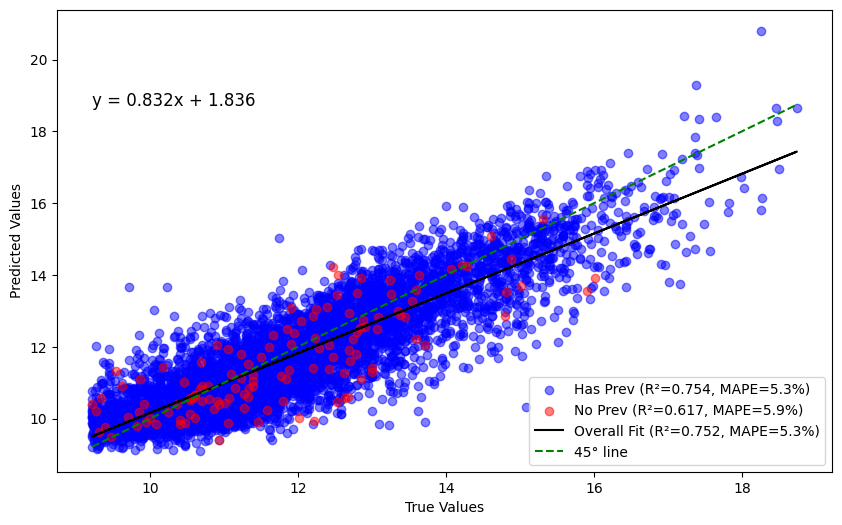

In [ ]:
if __name__ == '__main__':
  set_seed(1)
  # load numerical data
  artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
  artwork_numeric_data = pd.read_excel(artist_data_path)

  # image loading
  zip_path = "/content/drive/My Drive/pic.zip"
  extract_path = "/content/data"
  load_image_data(zip_path, extract_path)

  # Check for missing images and remove them
  base_dir = "/content/data"
  image_paths = artwork_numeric_data['image_url'].values
  missing_images = check_image_existence(image_paths, base_dir)
  data_filtered = filter_data_for_missing_images(artwork_numeric_data, missing_images, base_dir)

  # variables to select from df
  selected_vars =  ['category', 'artist', 'transaction_price', 'height',
                  'width', 'medium', 'transaction_house',
                    'transaction_year','transaction_date',
                    'location', 'prev_transaction_price', 'has_prev_price', 'aspect_ratio']
  # categorical variables for one-hot encoding
  one_hot_vars = ['category', 'artist', 'medium', 'transaction_house', 'location']

  # variables that need min-max scaling
  numerical_cols = ['height', 'width', 'transaction_year', 'aspect_ratio','prev_transaction_price']

  # preprocessing and train/test split
  X_train, X_test, y_train, y_test = data_split(data_filtered,
                                                 selected_vars,
                                                one_hot_vars,
                                                numerical_cols,
                                               2022)

  # sample checks
  print(f"Total test samples: {len(y_test)}")
  print(f"Test data shape : {X_test.shape}")
  print(f"Train data shape : {X_train.shape}")
  print("Std of y_test:", np.std(y_test))

  # initialize dataloaders for model training
  trainloader, testloader = create_dataloaders(X_train, X_test, y_train, y_test)

  # Initialize the model with the correct number of input features
  model = Numerical_Model(in_features=X_train.shape[1])

  # Train the model
  NumericalModel, prediction_numerical_model, target = train(model, trainloader,
                                                           testloader,
                                                           epochs = 30, eta =0.0001)
  # sample checks
  print(f"Total test batches: {len(testloader)}")
  print(f"Total test samples: {len(y_test)}")
  print(f"Test data shape : {X_test.shape}")
  print(f"Train data shape : {X_train.shape}")
  print("Std of y_test:", np.std(y_test))
  print("Std of predictions:", np.std(prediction_numerical_model))

  fit_visualization(X_test,target, prediction_numerical_model, save_path = "numerical.png")
  # OR, save just the state_dict (recommended)
  torch.save(NumericalModel.state_dict(), 'numerical_model_final_state_dict.pth')



In [ ]:
import itertools


# Grid search parameters

projection_dims = [50, 100]
lr_rates = [0.0001]
epochs = [20, 30]
batch_size = [32, 64]

results = []


for projection_dim, lr, epochs, batch_size in itertools.product(projection_dims, lr_rates, epochs, batch_size):
    print(f"\n Running: batch_size = {batch_size}, projection_dim={projection_dim}, rate = {lr}, epochs = {epochs}")

    # 1. Data split
    X_train, X_test, y_train, y_test = data_split(data_filtered,
                                                 selected_vars,
                                                one_hot_vars,
                                                numerical_cols,
                                               2022)

    # 2. Create dataloaders
    trainloader, testloader = create_dataloaders(X_train, X_test, y_train, y_test, batch_size=batch_size)

    # 3. Define model
    in_features = X_train.shape[1]
    model = Numerical_Model(in_features=in_features, projection_output_dim=projection_dim)

    # 4. Train model
    trained_model, predictions, targets = train(
        model,
        trainloader,
        testloader,
        epochs=epochs,
        eta= lr
    )

    # 5. Evaluate final test loss
    predictions = np.array(predictions)
    targets = np.array(targets)
    test_mse = np.mean((predictions - targets) ** 2)

    results.append({
        'batch_size': batch_size,
        'epochs': epochs,
        'projection_dim': projection_dim,
        'learning_rate': lr,
        'test_loss': test_mse
    })

    print(f" Finished: Test MSE = {test_mse:.4f}")

# Sort and show best configs
results = sorted(results, key=lambda x: x['test_loss'])
print("\n Top Grid Search Results:")
for r in results[:5]:
    print(r)


